In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
DATA_PATH = '3_spip'

## Download the data
Make function to get names from vcf files

In [3]:
def get_vcf_names(vcf_path):
    with open(vcf_path, "rt") as ifile:
          for line in ifile:
            if line.startswith("#CHROM"):
                  vcf_names = [x for x in line.split('\t')]
                  break
    return vcf_names

In [4]:
names = get_vcf_names(os.path.join(DATA_PATH, 
                                   'ABCA4_deep_intronic_indexed.vep.spliceai.pangolin.spip.vcf'))

ABCA4_path = os.path.join(DATA_PATH, 
                          'ABCA4_deep_intronic_indexed.vep.spliceai.pangolin.spip.vcf')
CRB1_path = os.path.join(DATA_PATH, 
                         'CRB1_deep_intronic_indexed.vep.spliceai.pangolin.spip.vcf')
USH2A_path = os.path.join(DATA_PATH, 
                          'USH2A_deep_intronic_SNP_indexed.vep.spliceai.pangolin.spip.vcf')

In [5]:
ABCA4_vcf = pd.read_csv(ABCA4_path, 
                        comment='#', 
                        sep='\t',
                        header=None, 
                        names=names)

CRB1_vcf = pd.read_csv(CRB1_path, 
                       comment='#', 
                       sep='\t', 
                       header=None, 
                       names=names)

USH2A_vcf = pd.read_csv(USH2A_path, 
                        comment='#', 
                        sep='\t', 
                        header=None, 
                        names=names)

In [6]:
ABCA4_vcf.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO\n
0,1,93993294,ENST00000370225.4:c.6817-55_6817-53del,GTAC,G,.,.,CSQ=-|intron_variant|MODIFIER|ABCA4|ENSG000001...
1,1,93993296,ENST00000370225.4:c.6817-54T>C,A,G,.,.,CSQ=G|intron_variant|MODIFIER|ABCA4|ENSG000001...
2,1,93993303,ENST00000370225.4:c.6817-61A>G,T,C,.,.,CSQ=C|intron_variant|MODIFIER|ABCA4|ENSG000001...
3,1,93993335,ENST00000370225.4:c.6817-93T>C,A,G,.,.,CSQ=G|intron_variant|MODIFIER|ABCA4|ENSG000001...
4,1,93993343,ENST00000370225.4:c.6817-102del,AG,A,.,.,CSQ=-|intron_variant|MODIFIER|ABCA4|ENSG000001...


In [7]:
CRB1_vcf.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO\n
0,1,197268533,ENST00000367400.8:c.70+51A>G,A,G,.,.,CSQ=G|intron_variant|MODIFIER|CRB1|ENSG0000013...
1,1,197268544,ENST00000367400.8:c.70+62A>C,A,C,.,.,CSQ=C|intron_variant|MODIFIER|CRB1|ENSG0000013...
2,1,197268557,ENST00000367400.8:c.70+75T>C,T,C,.,.,CSQ=C|intron_variant|MODIFIER|CRB1|ENSG0000013...
3,1,197268576,ENST00000367400.8:c.70+94T>C,T,C,.,.,CSQ=C|intron_variant|MODIFIER|CRB1|ENSG0000013...
4,1,197268580,ENST00000367400.8:c.70+99_70+104del,ATGCTAA,A,.,.,CSQ=-|intron_variant|MODIFIER|CRB1|ENSG0000013...


In [8]:
USH2A_vcf.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO\n
0,1,215625926,ENST00000307340.8:c.15520-56T>A,T,A,.,.,CSQ=A|downstream_gene_variant|MODIFIER|SNORD11...
1,1,215625926,ENST00000307340.8:c.15520-56T>C,T,C,.,.,CSQ=C|downstream_gene_variant|MODIFIER|SNORD11...
2,1,215625928,ENST00000307340.8:c.15520-58G>A,G,A,.,.,CSQ=A|downstream_gene_variant|MODIFIER|SNORD11...
3,1,215625929,ENST00000307340.8:c.15520-59T>C,T,C,.,.,CSQ=C|downstream_gene_variant|MODIFIER|SNORD11...
4,1,215625934,ENST00000307340.8:c.15520-64T>A,T,A,.,.,CSQ=A|downstream_gene_variant|MODIFIER|SNORD11...


 Collect all variants in the table

In [9]:
ABCA4_vcf['Gene'] = 'ABCA4'
CRB1_vcf['Gene'] = 'CRB1'
USH2A_vcf['Gene'] = 'USH2A'
total_table = pd.concat((ABCA4_vcf, CRB1_vcf, USH2A_vcf))

## Add the obtained tool scores

In [10]:
def process_spip(preds: list):
    _preds = preds.split(",")
    _max = 0
    for _p in _preds:
        score = float(_p.split("|")[4])
        if score > _max:
            _max = score
    return _max * 1000


def process_spliceai(preds: str):
    pred_list = preds.split('|')[2:6]
    max = 0
    for _ in pred_list:
        score = float(_)
        if score > max:
            max = score
    return max


def process_pangolin(pred):
    max = 0
    pred_list = pred.split('|')[1:3]
    for _ in pred_list:
        score = float(_.split(':')[1])
        if score > max:
            max = score
    return max


def spotlight_spliceai(pred):
    sai_score = 'Not predicted'
    prelim_list = pred['INFO\n'].split(';')
    for description in prelim_list:
        if description.startswith('SpliceAI='):
            sai_score = process_spliceai(description)
    return sai_score


def spotlight_spip(pred):
    spip_score = 'Not predicted'
    prelim_list = pred['INFO\n'].split(';')
    for description in prelim_list:
        if description.startswith('SPiP='):
            spip_score = process_spip(description)
    return spip_score


def spotlight_pangolin(pred):
    pang_score = 'Not predicted'
    prelim_list = pred['INFO\n'].split(';')
    for description in prelim_list:
        if description.startswith('Pangolin='):
            pang_score = process_pangolin(description)
    return pang_score
    

In [11]:
total_table['SpliceAI_score'] = total_table.apply(spotlight_spliceai, axis=1)

In [12]:
total_table['Pangolin_score'] = total_table.apply(spotlight_pangolin, axis=1)

In [13]:
total_table['SPiP_score'] = total_table.apply(spotlight_spip, axis=1)

## Prediction analysis

In [14]:
total_table.shape

(202313, 12)

In [15]:
total_table[total_table['SpliceAI_score'] != 'Not predicted'].count().iloc[0]

56307

In [16]:
total_table[total_table['Pangolin_score'] != 'Not predicted'].count().iloc[0]

62020

In [17]:
total_table[total_table['SPiP_score'] != 'Not predicted'].count().iloc[0]

202313

In [18]:
table_visual = total_table.copy()
table_visual.loc[table_visual['SpliceAI_score'] != 'Not predicted', 'SpliceAI_score'] = 'Predicted'
table_visual.loc[table_visual['Pangolin_score'] != 'Not predicted', 'Pangolin_score'] = 'Predicted'
table_visual.loc[table_visual['SPiP_score'] != 'Not predicted', 'SPiP_score'] = 'Predicted'

/var/folders/yn/8b9cs2_s6td7fmf54qzzqlj80000gn/T/ipykernel_1487/1083462592.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Predicted' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table_visual.loc[table_visual['SPiP_score'] != 'Not predicted', 'SPiP_score'] = 'Predicted'


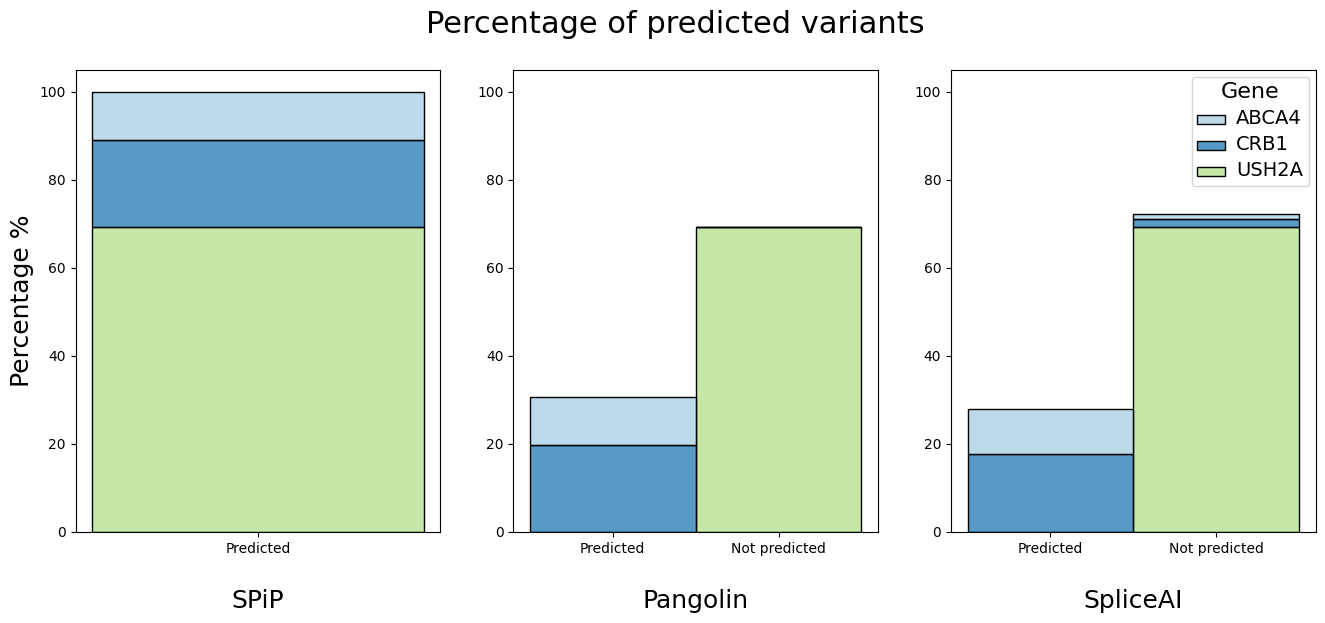

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
plt.suptitle('Percentage of predicted variants', fontsize=22)

sns.histplot(data=table_visual, 
             x='SPiP_score', hue='Gene',
             palette=sns.color_palette("Paired")[:3], 
             multiple="stack", ax=axes[0], legend=False, stat='percent')
axes[0].set_ylabel('Percentage %', fontsize=18)
axes[0].set_xlabel('\nSPiP', fontsize=18)
axes[0].set_ylim(0, 105)


sns.histplot(data=table_visual, 
             x='Pangolin_score', hue='Gene',
             palette=sns.color_palette("Paired")[:3], 
             multiple="stack", stat='percent', ax=axes[1], legend=False)
axes[1].set_xlabel('\nPangolin', fontsize=18)
axes[1].set_ylim(0, 105)
axes[1].set_ylabel('')


sns.histplot(data=table_visual, 
             x='SpliceAI_score', hue='Gene',
             palette=sns.color_palette("Paired")[:3], 
             multiple="stack", stat='percent')
axes[2].set_ylabel('')
axes[2].set_xlabel('\nSpliceAI', fontsize=18)
axes[2].set_ylim(0, 105)
plt.xlim(reversed(plt.xlim()))
plt.setp(axes[2].get_legend().get_texts(), fontsize='14')
plt.setp(axes[2].get_legend().get_title(), fontsize='16')
#plt.savefig("my_plot.png", bbox_inches="tight", dpi=300)
None

## Annotate variants

In [20]:
def annotate_prediction(line):
    if line['SpliceAI_score'] != 'Not predicted':
        sai_score = line['SpliceAI_score']
    else:
        sai_score = -10
    if line['Pangolin_score'] != 'Not predicted':
        pang_score = line['Pangolin_score']
    else:
        pang_score = -10
    if line['SPiP_score'] != 'Not predicted':
        spip_score = line['SPiP_score']
    else:
        spip_score = -10
    if (sai_score > 0.05 and 
        pang_score > 0.05 and 
        spip_score > 0.015):
        output = 'Pathogenic 🔴'
    elif (sai_score > 0.05 and pang_score > 0.05 and spip_score <= 0.015 or 
          sai_score <= 0.05 and pang_score > 0.05 and spip_score > 0.015 or 
          sai_score > 0.05 and pang_score <= 0.05 and spip_score > 0.015):
        output = 'Pathogenic 🟠'
    elif (sai_score > 0.05 and pang_score <= 0.05 and spip_score <= 0.015 or 
          sai_score <= 0.05 and pang_score > 0.05 and spip_score <= 0.015 or 
          sai_score <= 0.05 and pang_score <= 0.05 and spip_score > 0.015):
        output = 'Pathogenic 🟡'
    else:
        output = 'Benign 🟢'
    return output
    

In [21]:
total_table['Prediction'] = total_table.apply(annotate_prediction, axis=1)

In [22]:
total_table[total_table['Prediction'] == 'Pathogenic 🔴'].count().iloc[0]

158

In [23]:
total_table[total_table['Prediction'] == 'Pathogenic 🟠'].count().iloc[0]

488

In [24]:
total_table[total_table['Prediction'] == 'Pathogenic 🟡'].count().iloc[0]

9301

In [25]:
total_table[total_table['Prediction'] == 'Benign 🟢'].count().iloc[0]

192366

## Create result table

In [26]:
total_table.columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO\n', 'Gene',
       'SpliceAI_score', 'Pangolin_score', 'SPiP_score', 'Prediction'],
      dtype='object')

In [27]:
new_names = {'#CHROM':'Chrom', 
             'POS': 'Position', 
             'ID': 'HGVSc', 
             'REF': 'Ref', 
             'ALT': 'Alt'}

result_table = total_table[['#CHROM', 'Gene', 'POS', 'ID', 'REF', 'ALT', 
                            'SpliceAI_score', 'Pangolin_score', 'SPiP_score', 
                             'Prediction']].rename(columns=new_names)

In [28]:
result_table.shape

(202313, 10)

Save the result

In [ ]:
#result_table.to_csv('ABCA4_CRB1_USH2A_annot.csv', index=False)